In [8]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import inv
import sklearn

In [9]:
def grad(Q,p,A,b,t,v):
    return t*((Q.T+Q).dot(v)+p) + np.sum((1/(b-A.dot(v)).T)*A.T, axis=1).reshape(-1,1)

def hessian(Q,p,A,b,t,v):
    temp = b-A.dot(v)
    return 2*t*Q + sum([1/(temp[i])**2 * A[i,].reshape(-1,1).dot(A[i,].reshape(1,-1)) for i in range(A.shape[0])])

def f(Q,p,A,b,t,v):
    if not (b-A.dot(v)>0).all():
        raise Exception('Fail. Not feasible')
    return t*(v.T@Q@v + p.T.dot(v)) - np.sum(np.log(b-A.dot(v)))

def line_search(Q,p,A,b,t,v,delta,alpha,beta):
    rate = 1
    while not(((b-A.dot(v+rate*delta))>0).all()) or (f(Q,p,A,b,t,v+rate*delta) > f(Q,p,A,b,t,v) + alpha*rate*grad(Q,p,A,b,t,v).T.dot(delta)):
        rate = beta*rate
    return rate

def centering_step(Q,p,A,b,t,v0,eps):
    alpha = 0.01  #to be determined
    beta = 0.5   #to be determined
    
    res = [v0]
    iter_newt = 0
    while 1:
        
        delta_newt = -inv(hessian(Q,p,A,b,t,v0)).dot(grad(Q,p,A,b,t,v0))
        lambda_sq = -grad(Q,p,A,b,t,v0).T.dot(delta_newt)
        if lambda_sq/2 <= eps:
            break
        else:
            iter_newt += 1
            rate = line_search(Q,p,A,b,t,v0,delta_newt,alpha,beta)
            v0 = v0 + rate*delta_newt
            res.append(v0)
    return (res[-1], iter_newt)


In [10]:
def barr_method(Q,p,A,b,v0,eps,mu):
    t = 1  #to be determined
    m = A.shape[0]
    res = [v0]
    iters_newt = [0]
    while 1:
        v0, iter_newt = centering_step(Q,p,A,b,t,v0,0.00001)
        res.append(v0)
        iters_newt.append(iters_newt[-1]+iter_newt)
        if m/t < eps:
            break
        else:
            t = mu*t
    return (res, iters_newt)
        


In [11]:
from sklearn.datasets import make_regression
n =10
d = 50

np.random.seed(42)
X,y,coef = make_regression(n_samples=n, n_features=d, n_informative=10, coef=True, noise = 1)
y = y.reshape((-1,1))

lambd = 10

Q = 0.5*np.eye(n)
p = -y
A = np.vstack((X.T,-X.T))
b = lambd*np.ones((2*d,1))
v0 = np.zeros((n,1))
eps = 0.001

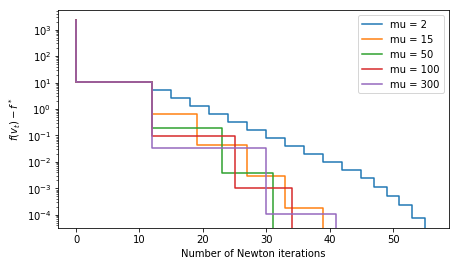

In [12]:
plt.figure(figsize=(7,4)) 
for mu in [2,15,50,100,300]:
    v_traj, iters_newt = barr_method(Q,p,A,b,v0,0.001,mu)
    v_last = v_traj[-1]
    values = [(v0.T@Q@v0 + p.T.dot(v0))[0,0] - (v_last.T@Q@v_last + p.T.dot(v_last))[0,0] for v0 in v_traj]
    plt.step(iters_newt, values, label='mu = '+str(mu))
plt.legend(loc = 'upper right')
plt.semilogy()
plt.xlabel('Number of Newton iterations')
plt.ylabel('$f(v_t)-f^*$')
plt.savefig("plot.eps")
plt.show()